<a href="https://colab.research.google.com/github/Likhithluck/Capstone-Project/blob/likhith/Another_copy_of_Initial_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load the dataset
ds = load_dataset("mychen76/invoices-and-receipts_ocr_v1")

# Check dataset structure
print(ds)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 2043
    })
    test: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 125
    })
    valid: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 70
    })
})


In [ ]:
def display(image):
    dpi = 80

    # If the input is a file path, load the image
    if isinstance(image, str):
        im_data = plt.imread(image)
    elif isinstance(image, Image.Image):  # If it's a PIL Image
        im_data = np.array(image)  # Convert PIL Image to NumPy array
    else:
        raise ValueError("Input should be a file path or a PIL Image object.")

    height, width  = im_data.shape[:2]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

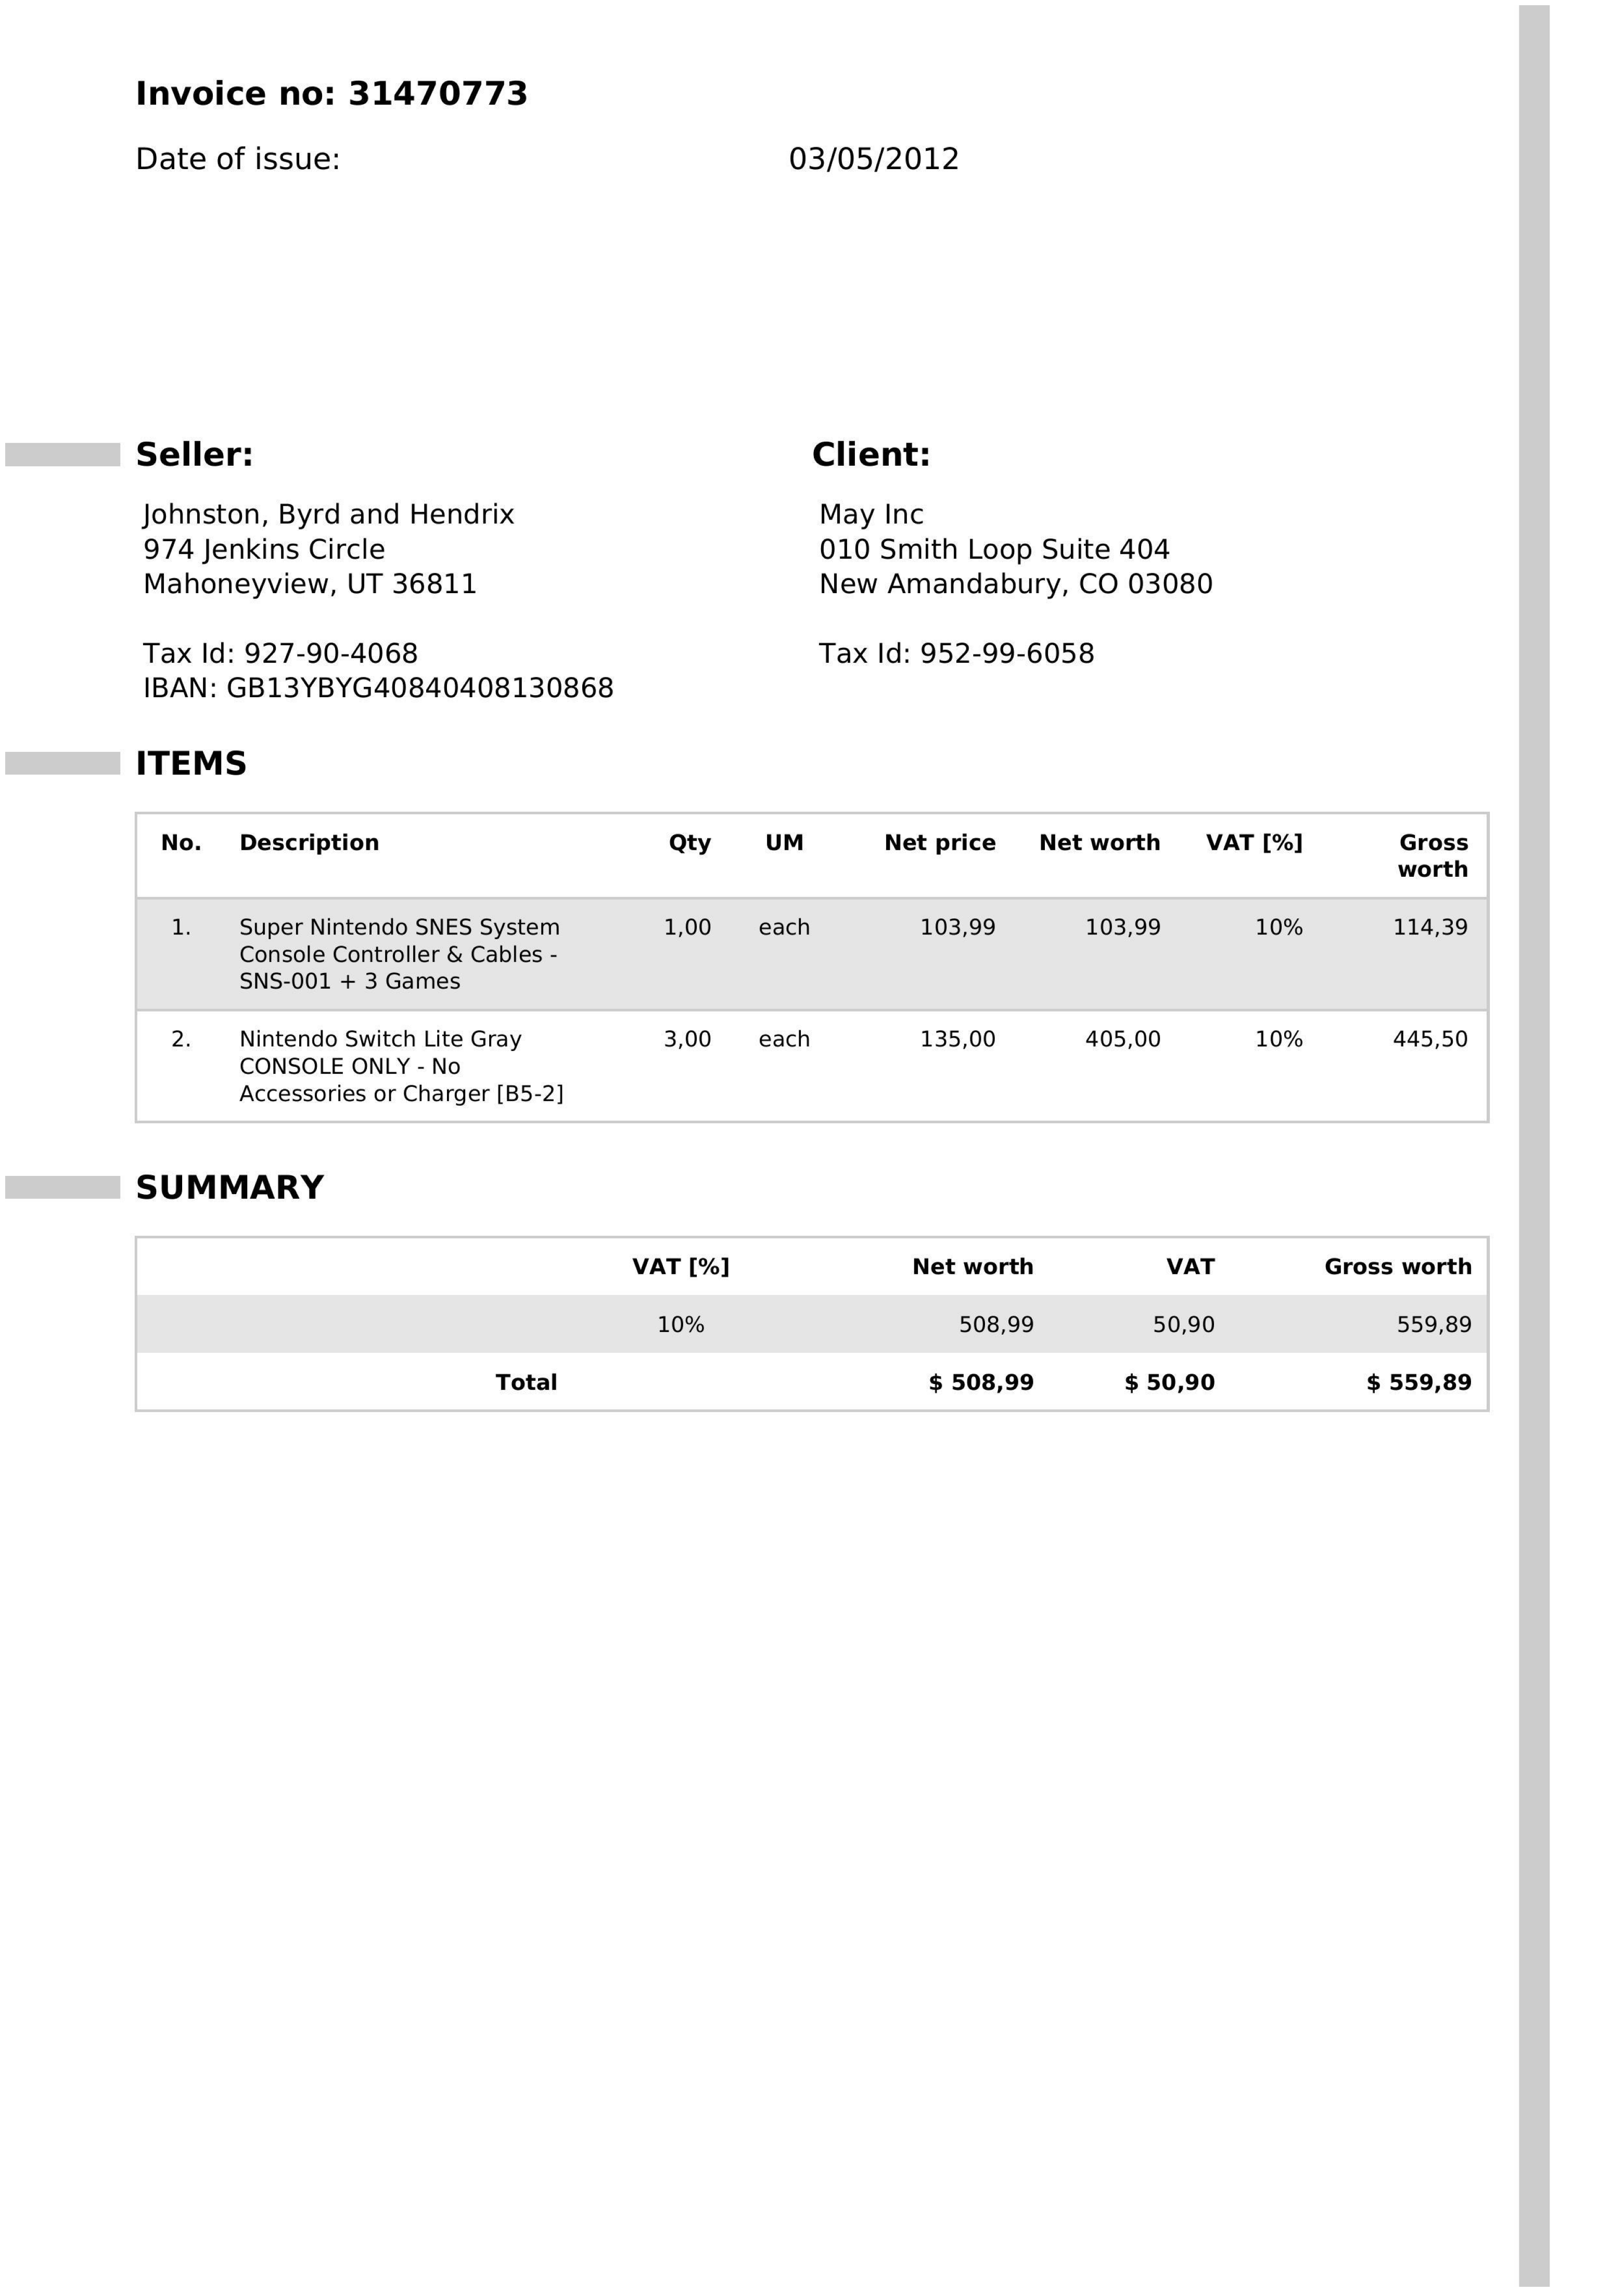

In [ ]:
# Get an image from the dataset
sample_image = ds["train"][200]["image"]  # PIL Image object

# Display the image
display(sample_image)

In [ ]:
import pytesseract

extracted_text = pytesseract.image_to_string(sample_image)

# Print the extracted text
print(extracted_text)

Invoice no: 31470773

Date of issue:

Seller:

Johnston, Byrd and Hendrix
974 Jenkins Circle
Mahoneyview, UT 36811

Tax Id: 927-90-4068
IBAN: GB13YBYG40840408130868

ITEMS

No. Description

1. Super Nintendo SNES System
Console Controller & Cables -
SNS-001 + 3 Games

2. Nintendo Switch Lite Gray
CONSOLE ONLY - No
Accessories or Charger [B5-2]

SUMMARY

Total

Qty

1,00

3,00

VAT [%]

10%

03/05/2012

UM

each

each

Client:

May Inc
010 Smith Loop Suite 404
New Amandabury, CO 03080

Tax Id: 952-99-6058

Net price Net worth VAT [%]
103,99 103,99 10%
135,00 405,00 10%

Net worth VAT
508,99 50,90
$ 508,99 $ 50,90

Gross
worth

114,39

445,50

Gross worth
559,89

$ 559,89



In [ ]:
#function to extract Invoice no

import re

# Function to extract the invoice number
def extract_invoice_number(text):
    # Search for a line that starts with "Invoice no:"
    match = re.search(r"Invoice no:\s*(\d+)", text)
    if match:
        return match.group(1)  # Return the invoice number
    return None  # Return None if no invoice number is found

In [ ]:
invoice_number = extract_invoice_number(extracted_text)
print("Invoice Number:", invoice_number)

Invoice Number: 31470773


In [ ]:
#function for extracting date

import re
from datetime import datetime

def extract_date(ocr_text):
    # Define possible date patterns
    date_patterns = [
        r'\b(\d{1,2}/\d{1,2}/\d{4})\b',  # Matches MM/DD/YYYY or DD/MM/YYYY
        r'\b(\d{4}-\d{1,2}-\d{1,2})\b'   # Matches YYYY-MM-DD
    ]

    # Try matching different patterns
    for pattern in date_patterns:
        match = re.search(pattern, ocr_text)
        if match:
            raw_date = match.group(1)  # Extracted date string

            # Convert date to standard format (YYYY-MM-DD)
            for fmt in ("%m/%d/%Y", "%d/%m/%Y", "%Y-%m-%d"):
                try:
                    formatted_date = datetime.strptime(raw_date, fmt).strftime("%Y-%m-%d")
                    return formatted_date
                except ValueError:
                    continue

    return None  # Return None if no date is found

In [ ]:
extracted_date = extract_date(extracted_text)
print("Date of issue:", extracted_date)

Date of issue: 2012-03-05


In [ ]:
import json

# Function to extract seller and client details
def extract_details(text):
    lines = text.split("\n")

    seller_name, seller_address, seller_tax, seller_iban = "", "", "", ""
    client_name, client_address, client_tax = "", "", ""

    seller_section, client_section = False, False
    seller_lines, client_lines = [], []

    for line in lines:
        line = line.strip()

        if line.startswith("Seller:"):
            seller_section = True
            client_section = False
            continue
        elif line.startswith("Client:"):
            seller_section = False
            client_section = True
            continue

        if seller_section:
            seller_lines.append(line)
        elif client_section:
            client_lines.append(line)

    # Extract Seller Details
    if seller_lines:
        seller_name = seller_lines[0]
        seller_address = " ".join(seller_lines[1:3])  # Join address lines
        for line in seller_lines:
            if "Tax Id:" in line:
                seller_tax = line.split(":")[1].strip()
            if "IBAN:" in line:
                seller_iban = line.split(":")[1].strip()

    # Extract Client Details
    if client_lines:
        client_name = client_lines[0]
        client_address = " ".join(client_lines[1:3])  # Join address lines
        for line in client_lines:
            if "Tax Id:" in line:
                client_tax = line.split(":")[1].strip()

    extracted_details = {
        "Seller": {
            "Name": seller_name,
            "Address": seller_address,
            "Tax ID": seller_tax,
            "IBAN": seller_iban
        },
        "Client": {
            "Name": client_name,
            "Address": client_address,
            "Tax ID": client_tax
        }
    }

    return extracted_details

# Extract and print in JSON format
structured_data = extract_details(extracted_text)
print(json.dumps(structured_data, indent=4))


{
    "Seller": {
        "Name": "",
        "Address": "Johnston, Byrd and Hendrix 974 Jenkins Circle",
        "Tax ID": "927-90-4068",
        "IBAN": "GB13YBYG40840408130868"
    },
    "Client": {
        "Name": "",
        "Address": "May Inc 010 Smith Loop Suite 404",
        "Tax ID": "952-99-6058"
    }
}


In [ ]:
#function for extracting seller and client details

import json

def extract_details(text):
    lines = text.split("\n")

    seller_name, seller_address, seller_tax, seller_iban = "", "", "", ""
    client_name, client_address, client_tax = "", "", ""

    seller_section, client_section = False, False
    seller_lines, client_lines = [], []

    for line in lines:
        line = line.strip()

        if line.startswith("Seller:"):
            seller_section = True
            client_section = False
            continue
        elif line.startswith("Client:"):
            seller_section = False
            client_section = True
            continue

        if seller_section:
            seller_lines.append(line)
        elif client_section:
            client_lines.append(line)

    # Extract Seller Details
    if seller_lines:
        # Skip the first empty line after "Seller:"
        seller_name = seller_lines[0] if seller_lines[1] == "" else seller_lines[1]
        seller_address = " ".join(seller_lines[2:4])  # Join address lines
        for line in seller_lines:
            if "Tax Id:" in line:
                seller_tax = line.split(":")[1].strip()
            if "IBAN:" in line:
                seller_iban = line.split(":")[1].strip()

    # Extract Client Details
    if client_lines:
        # Skip the first empty line after "Client:"
        client_name = client_lines[0] if client_lines[1] == "" else client_lines[1]
        client_address = " ".join(client_lines[2:4])  # Join address lines
        for line in client_lines:
            if "Tax Id:" in line:
                client_tax = line.split(":")[1].strip()

    extracted_details = {
        "Seller": {
            "Name": seller_name,
            "Address": seller_address,
            "Tax ID": seller_tax,
            "IBAN": seller_iban
        },
        "Client": {
            "Name": client_name,
            "Address": client_address,
            "Tax ID": client_tax
        }
    }

    return extracted_details


In [ ]:
structured_data = extract_details(extracted_text)
print(json.dumps(structured_data, indent=4))

{
    "Seller": {
        "Name": "Johnston, Byrd and Hendrix",
        "Address": "974 Jenkins Circle Mahoneyview, UT 36811",
        "Tax ID": "927-90-4068",
        "IBAN": "GB13YBYG40840408130868"
    },
    "Client": {
        "Name": "May Inc",
        "Address": "010 Smith Loop Suite 404 New Amandabury, CO 03080",
        "Tax ID": "952-99-6058"
    }
}
